In [3]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support
import time
from datetime import datetime


# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity
pd.set_option('display.max_rows', None)


In [4]:
# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)


val_and_test_sets = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

from torch.utils.data import DataLoader, random_split

# Define the sizes or proportions of the two sets
test_size = int(0.5 * len(val_and_test_sets))
val_size = len(val_and_test_sets) - test_size  # Remaining data for validation

# Split the dataset into two separate datasets
test_dataset, val_dataset = random_split(val_and_test_sets, [test_size, val_size])

# Create separate DataLoader instances for training and validation sets
test_dataloader = DataLoader(test_dataset, batch_size=1000)
val_dataloader = DataLoader(val_dataset, batch_size=1000)



In [16]:
# helper function to calculate all predictions of train set
def get_all_preds(model, loader, get_loss=True):
  all_preds = torch.tensor([]).to('cuda')
  total_loss = 0
  for batch in loader:
    images, labels = batch
    images = images.to('cuda:0')
    labels = labels.to('cuda:0')
    
    preds = model(images)
    loss = F.cross_entropy(preds, labels)
    total_loss += loss
    all_preds = torch.cat(
        (all_preds, preds),
        dim = 0
    )
  if get_loss:
    return total_loss.item() / len(loader)
  else:
    return all_preds


In [6]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding='same') #28
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5) #24
    self.conv3 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=5, padding='same') # 12 (post max pool)
    self.conv4 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=5) # 8
    self.conv5 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=5) # 4

    self.fc1 = nn.Linear(in_features=48*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)
    
    # self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, padding='same') #28
    # self.conv2 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5) #24
    # self.conv3 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5, padding='same') # 12 (post max pool)
    # self.conv4 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5) # 8
    # self.conv5 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5) # 4

    # self.fc1 = nn.Linear(in_features=4*4*4, out_features=120)
    # self.fc2 = nn.Linear(in_features=120, out_features=60)
    # self.out = nn.Linear(in_features=60, out_features=10)

  # define forward function
  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = F.relu(t)
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2) #24->12

    t = self.conv3(t)
    t = F.relu(t)
    t = self.conv4(t)
    t = F.relu(t)
    # t = F.max_pool2d(t, kernel_size=2, stride=2) 
    
    t = self.conv5(t)
    t = F.relu(t)

    # fc1
    t = t.reshape(-1, 48*4*4)
    # t = t.reshape(-1, 4*4*4)
    t = self.fc1(t)
    t = F.relu(t)

    # fc2
    t = self.fc2(t)
    t = F.relu(t)

    # output
    t = self.out(t)
    # don't need softmax here since we'll use cross-entropy as activation.

    return t


In [42]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()


# import modules to build RunBuilder and RunManager helper classes
from collections  import OrderedDict
from collections import namedtuple
from itertools import product

# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs


# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None
    self.lowest_val_loss_value = 0
    self.lowest_val_loss_num_epoch = 0

    # record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.tb = None

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    
    self.lowest_val_loss_value = float('inf')
    self.lowest_val_loss_num_epoch = 0
    
    current_timestamp = time.time()
    current_date = datetime.fromtimestamp(current_timestamp).strftime("%d-%m-%y")

    self.tb = SummaryWriter(log_dir=f'/home/yoni/Desktop/f/model_output/tboard/{current_date + "-" + str(current_timestamp).split(".")[0]}')

    images, labels = next(iter(self.loader))
    images = images.to('cuda')
    
    grid = torchvision.utils.make_grid(images)
    # grid.to('cuda')

    self.tb.add_image('images', grid)
    self.tb.add_graph(self.network, images)

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.tb.close()
    self.epoch_count = 0

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0

  # 
  def end_epoch(self, network):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)
    
    # Calculate the validation loss
    network.eval()
    val_loss = get_all_preds(network, val_dataloader)
    network.train()
    
    # Record epoch loss and accuracy to TensorBoard 
    self.tb.add_scalar('Train loss', loss, self.epoch_count)
    self.tb.add_scalar('Val loss', val_loss, self.epoch_count)
    self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)
    
    if val_loss < self.lowest_val_loss_value:
      self.lowest_val_loss_value = val_loss
      self.lowest_val_loss_num_epoch = self.epoch_count
      model_path = f'/home/yoni/Desktop/f/model_output/network_params/model_clothing_type_detect_{self.run_count}_lowest_val_loss.pth'
      print(model_path)
      torch.save({
            'epoch': self.epoch_count,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            }, model_path)

      
    # Record params to TensorBoard
    for name, param in self.network.named_parameters():
      self.tb.add_histogram(name, param, self.epoch_count)
      self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
      pass
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration
    results["val loss"] = self.lowest_val_loss_value
    results["lowest val loss"] = self.lowest_val_loss_num_epoch

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): 
      results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait=True)
    display(df)
    
    return self.epoch_count - self.lowest_val_loss_num_epoch > 7
  

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
  
  # save end results of all runs into csv, json for further a
  def save(self, fileName):

    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

    with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
      json.dump(self.run_data, f, ensure_ascii=False, indent=4)

# put all hyper params into a OrderedDict, easily expandable
params = OrderedDict(
    lr = [.001],#.01, 
    batch_size = [100],
    shuffle = [False]
)
epochs = 60
     
     
m = RunManager()

# get all runs from params using RunBuilder class
for run in RunBuilder.get_runs(params):

    # if params changes, following line of code should reflect the changes too
    network = Network()
    network = network.to('cuda:0')
    loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size)
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, loader)
    for epoch in range(epochs):
      
      m.begin_epoch()
      for batch in loader:
        
        images = batch[0].to('cuda:0')
        labels = batch[1].to('cuda:0')
        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(preds, labels)

      should_run_terminate = m.end_epoch(network)
      if should_run_terminate:
        break
    m.end_run()

# when all runs are done, save results to files
m.save('results')

torch.cuda.empty_cache() 

,run,epoch,loss,accuracy,epoch duration,run duration,val loss,lowest val loss,lr,batch_size,shuffle
0,1,1,0.653978,0.749850,4.974370,5.017798,0.504134,1,0.001,100,False
1,1,2,0.378999,0.858817,4.972725,10.159502,0.367233,2,0.001,100,False
2,1,3,0.310149,0.886133,4.870810,15.202274,0.313113,3,0.001,100,False
3,1,4,0.269445,0.901100,4.834568,20.207202,0.292979,4,0.001,100,False
4,1,5,0.242933,0.910883,4.656455,25.032222,0.279199,5,0.001,100,False
5,1,6,0.222641,0.918433,4.653877,29.853426,0.279199,5,0.001,100,False
6,1,7,0.203715,0.926333,4.747415,34.767627,0.275746,7,0.001,100,False
7,1,8,0.185429,0.931733,4.986175,39.924699,0.275746,7,0.001,100,False
8,1,9,0.171526,0.937467,4.857921,44.952600,0.275746,7,0.001,100,False
9,1,10,0.158665,0.941883,4.646165,49.785024,0.275746,7,0.001,100,False


In [43]:
torch.cuda.empty_cache() 
checkpoint = torch.load('/home/yoni/Desktop/f/model_output/network_params/model_clothing_type_detect_1_lowest_val_loss.pth')
network.load_state_dict(checkpoint['model_state_dict'])
val_and_test_loader = torch.utils.data.DataLoader(val_and_test_sets, batch_size=1000)
val_and_test_preds = get_all_preds(network, val_and_test_loader, get_loss=False)

[[936   0   9  21   2   2  26   0   4   0]
 [  1 976   0  16   2   0   4   0   1   0]
 [ 31   1 865  15  43   0  42   0   3   0]
 [ 13   3   5 950  15   0  10   0   4   0]
 [  1   1  52  34 855   0  56   0   1   0]
 [  0   0   0   1   0 956   0  29   1  13]
 [214   1  69  34  54   0 614   0  14   0]
 [  0   0   0   0   0   5   0 984   1  10]
 [ 10   0   2   4   1   1   1   4 977   0]
 [  0   0   0   0   0   4   0  40   0 956]]


<Axes: title={'center': 'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

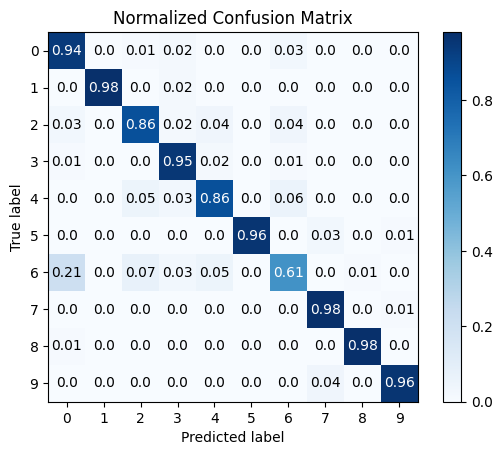

In [44]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import scikitplot as skplt

cm = confusion_matrix(val_and_test_sets.targets, val_and_test_preds.argmax(dim=1).cpu())
print(cm)
skplt.metrics.plot_confusion_matrix(val_and_test_sets.targets,val_and_test_preds.argmax(dim=1).cpu(), normalize=True)

In [45]:
pytorch_total_params = sum(p.numel() for p in network.parameters() if p.requires_grad)
print(f' num params {pytorch_total_params}')
torch.cuda.empty_cache() 

 num params 312374


In [ ]:
prediction_mapper = {0:'T-shirt/top', 1:	'Trouser',2:	'Pullover',3:	'Dress',4:	'Coat',5:	'Sandal',6:	'Shirt',7:	'Sneaker',8:	'Bag', 9:	'Ankle boot'}

import os, cv2
import matplotlib.pyplot as plt
imgs = []
img_paths = []
base_dir = '/home/yoni/Desktop/test_images/coats/'
for filename in os.listdir(base_dir):
  img = cv2.imread(os.path.join(base_dir, filename),0)
  img_paths.append(os.path.join(base_dir, filename))
  imgs.append(img)
  plt.imshow(img, cmap='gray')
  plt.axis('off')  # Optional: Disable axis
  plt.show()



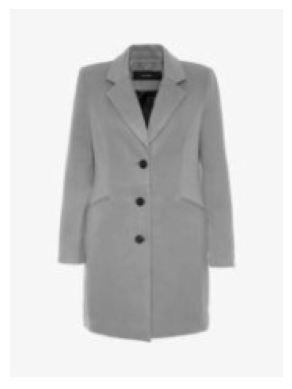

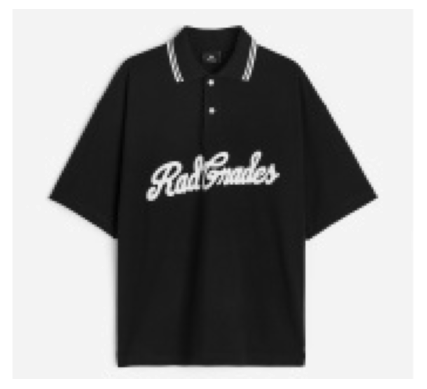

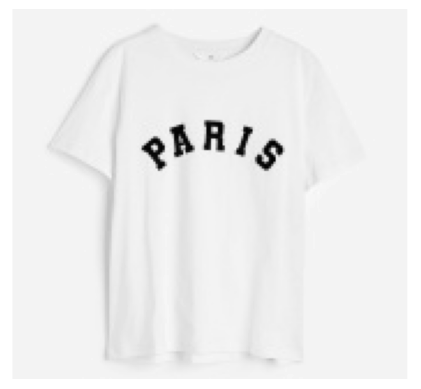

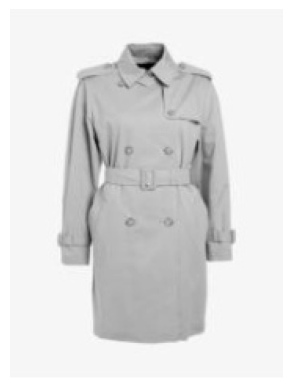

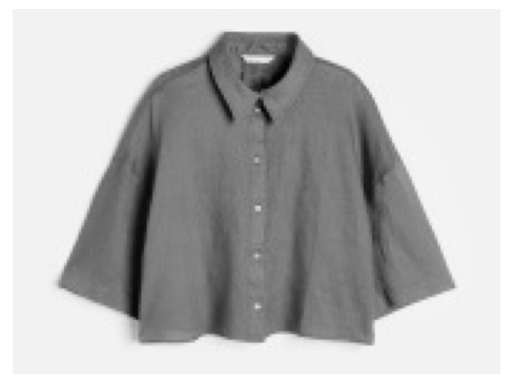

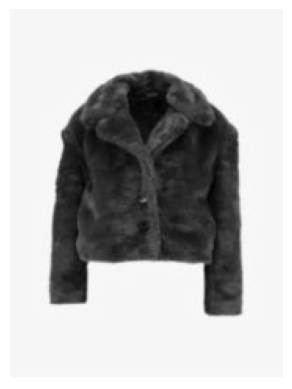

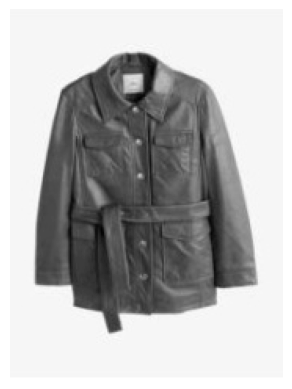

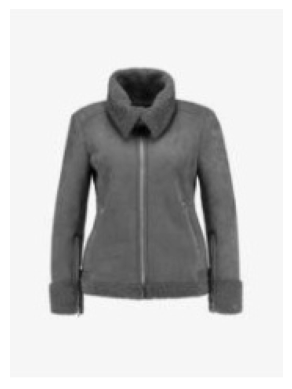

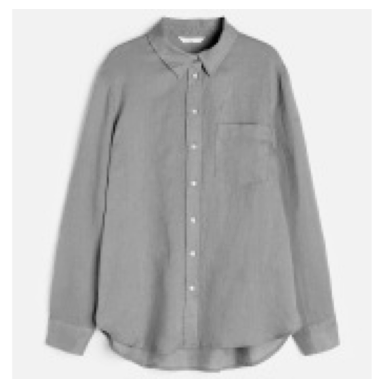

In [141]:
# def crop_clothing(img):
import numpy as np
new_imgs = []
for img in imgs:
  row_idx,col_idx = img.shape
  row_idx-=1
  col_idx-=1
    
  while row_idx > img.shape[0]//2:
    if np.all(img[row_idx]==img[img.shape[0]-row_idx]):
      row_idx -= 1
    else:
      break
  while col_idx > img.shape[1]//2:
    if np.all(img[col_idx]==img[img.shape[1]-col_idx]):
      col_idx -= 1
    else:
      break

  new_img = img[img.shape[0]-row_idx:row_idx,img.shape[1]-col_idx:col_idx]
  new_imgs.append(new_img)

for new_img in new_imgs:
  plt.imshow(new_img, cmap='gray')
  plt.axis('off')  # Optional: Disable axis
  plt.show()

In [70]:
def resize_img(target_width:int, target_height:int,img=None) -> np.ndarray:
    
    if img is None:
        img = cv2.imread(input_img_path)
    
    # Get the original width and height
    original_height, original_width = img.shape[:2]
    
    # Calculate the aspect ratio
    aspect_ratio = original_width / original_height
    
    # Calculate the new width and height based on the aspect ratio
    if target_width / aspect_ratio <= target_height:
        new_width = target_width
        new_height = round(target_width / aspect_ratio)
    else:
        new_width = round(target_height * aspect_ratio)
        new_height = target_height
    
    # Resize the image while maintaining the aspect ratio
    resized_image = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    # Create a new blank image with the target width and height
    padded_image = np.ones((target_height, target_width), dtype=np.uint8) * 255
    
    # Calculate the position to paste the resized image to center it
    pad_x = (target_width - new_width) // 2
    pad_y = (target_height - new_height) // 2
    
    # Paste the resized image onto the padded image
    padded_image[pad_y:pad_y+new_height, pad_x:pad_x+new_width] = resized_image
    
    
    return padded_image

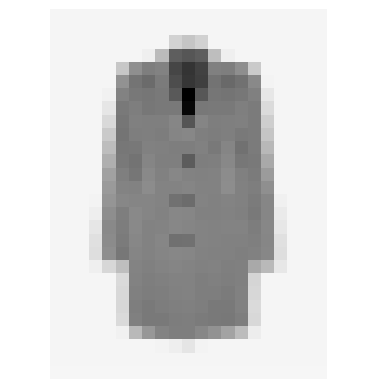

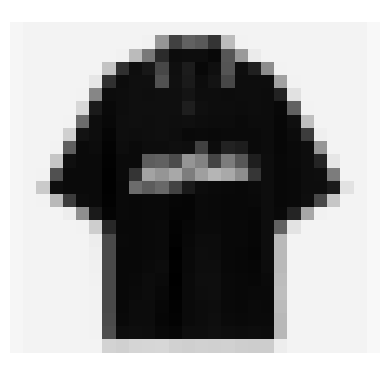

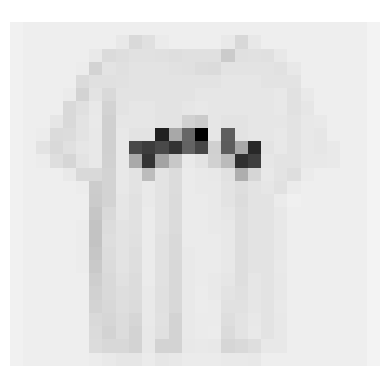

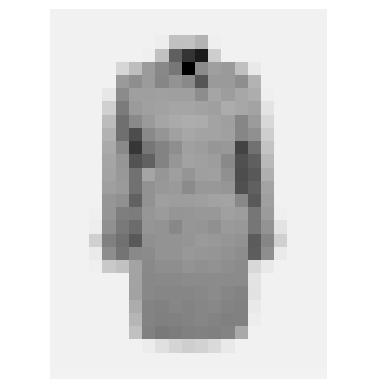

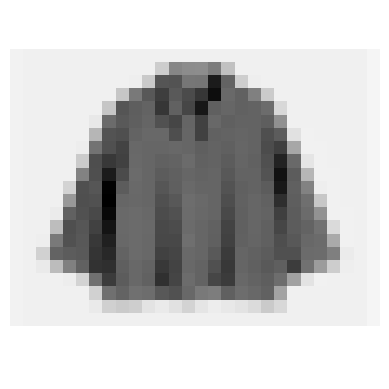

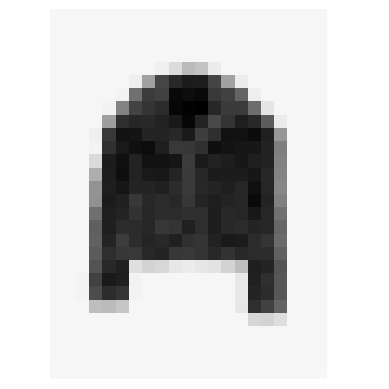

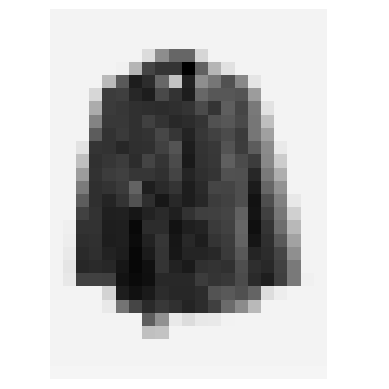

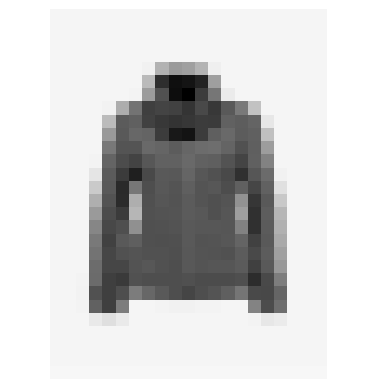

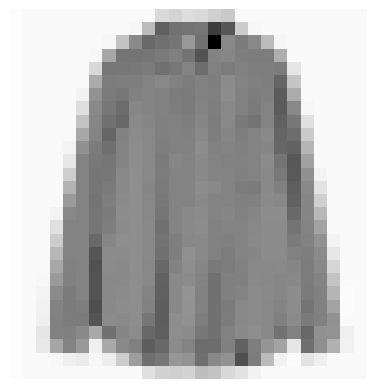

In [145]:
resized_imgs = [np.array(resize_img(28,28,img=img), dtype=np.float32) for img in new_imgs]
for img in resized_imgs:
  plt.imshow(img, cmap='gray')
  plt.axis('off')  # Optional: Disable axis
  plt.show()


In [143]:

network = Network()

checkpoint = torch.load('/home/yoni/Desktop/f/model_output/network_params/model_clothing_type_detect_good.pth')
network.load_state_dict(checkpoint['model_state_dict'])
network.eval()

resized_imgs = [torch.from_numpy(resized_img).unsqueeze(0) for resized_img in resized_imgs]
resized_imgs = torch.stack(resized_imgs)
predictions = network(resized_imgs)
# resized_imgs.shape




In [144]:
for pred in predictions:
  print(prediction_mapper[np.argmax(pred.detach().numpy())])

Shirt
Bag
Bag
Bag
T-shirt/top
T-shirt/top
Bag
T-shirt/top
Bag
